In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
import pandas as pd
import statistics as stat
%matplotlib inline

In [2]:
from keras.datasets import boston_housing
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

Using TensorFlow backend.


### Данные:
Будем работать с датасетом [Boston Housing Prices](https://medium.com/@haydar_ai/learning-data-science-day-9-linear-regression-on-boston-housing-dataset-cd62a80775ef).

Text(0.5,0,'Price')

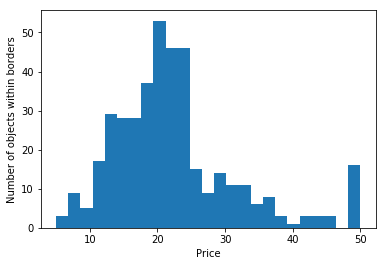

In [3]:
plt.hist(y_train, bins=25)
plt.ylabel('Number of objects within borders')
plt.xlabel('Price')

### Задание.
Будем решать задачу регрессии. Целевая переменная -- цена дома, признаки - различная информация о домохозяйстве. Для решения будем использовать линейную регрессию. Ваша задача - оценить качество решения в зависимости от количества объектов в обучающей выборке. Качество решения будем оценивать с помощью среднеквадратичной и среднеабсолютной ошибки, а так же [коэффициента детерминации $r^2$](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination). Также требуется оценить дисперсию данных функционалов в зависимости от числа объектов в обучающей выборке. 

### Разберемся с данными:

Структурируем данные, так как это может облегчить их обработку.

In [4]:
from sklearn.datasets import load_boston

In [5]:
boston = load_boston()

In [6]:
lables = boston.feature_names

In [7]:
data_train = pd.DataFrame(data = X_train, index = range(1, len(X_train)+1), columns = lables)
data_test = pd.DataFrame(data = X_test, index = range(1, len(X_test)+1), columns = lables)

In [8]:
data_train.insert(value = y_train, column = 'PRICE', loc = 13)
data_test.insert(value = y_test, column = 'PRICE', loc = 13)

In [9]:
data_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
1,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
2,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
3,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
4,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
5,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


In [10]:
data_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
1,18.08460,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05,7.2
2,0.12329,0.0,10.01,0.0,0.547,5.913,92.9,2.3534,6.0,432.0,17.8,394.95,16.21,18.8
3,0.05497,0.0,5.19,0.0,0.515,5.985,45.4,4.8122,5.0,224.0,20.2,396.90,9.74,19.0
4,1.27346,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50,27.0
5,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2


In [11]:
print("Размер предлагаемой обучающей выборки: {} объекта".format(data_train.shape[0]))
print("Размер предлагаемой тестовой выборки: {} объекта".format(data_test.shape[0]))

Размер предлагаемой обучающей выборки: 404 объекта
Размер предлагаемой тестовой выборки: 102 объекта


### Используем линейную модель регрессии (cначала рассмотрим ее работу на предлагаемой выборке):

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Text(0.5,1,'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

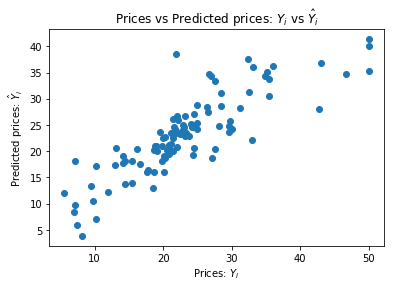

In [13]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [14]:
print('mae = {}'.format(mean_absolute_error(y_test, y_pred)))
print('mse = {}'.format(mean_squared_error(y_test, y_pred)))
print('r2 score = {}'.format(r2_score(y_test, y_pred)))
print('prediction variance = {}'.format(np.std((y_test - y_pred)**2)))

mae = 3.4641858124068388
mse = 23.195599256424643
r2 score = 0.7213535934621352
prediction variance = 45.780486850341056


### Теперь будем оценивать качество модели, получая значения ошибок и r2-score:

In [15]:
# Будем варьировать длину выборки с помощью параметра l_train: от 50% до 390% относительно длины тестовой выборки
# Число повторений для l_train случайных объектов равно k
parameters = {"k": range(20), "l_train": np.arange(0.5, 3.9, 0.1)}
# Запишем результаты сюда
error_results_test = {"mae": [], "mse": [], "r2": [], "var": {'mae_mean': [], 'mae_var': [], 'mse_mean': [], 'mse_var': [], 'r2_mean': [], 'r2_var': []}}
error_results_train = {"mae": [], "mse": [], "r2": [], "var": {'mae_mean': [], 'mae_var': [], 'mse_mean': [], 'mse_var': [], 'r2_mean': [], 'r2_var': []}}

In [16]:
test_data_size = data_test.shape[0] # test data will be always the same

for l_train in parameters['l_train']:
    intermediate_error_results_test = {"mae": [], "mse": [], "r2": []}
    intermediate_error_results_train = {"mae": [], "mse": [], "r2": []}
    for k in parameters['k']:
        train_data_size = int(np.around(test_data_size * l_train, decimals = 0))
        indices = np.random.permutation(range(train_data_size))
        train = data_train.iloc[indices[:train_data_size]]
        test = data_test
        
        lm = LinearRegression()
        lm.fit(train[lables[:len(lables)-1]], train['PRICE'])
        
        y_pred_test = lm.predict(test[lables[:len(lables)-1]])
        mae = mean_absolute_error(y_test, y_pred_test)
        intermediate_error_results_test['mae'].append(mae)
        mse = mean_squared_error(y_test, y_pred_test)
        intermediate_error_results_test['mse'].append(mse)
        r2 = r2_score(y_test, y_pred_test)
        intermediate_error_results_test['r2'].append(r2)
        
        y_pred_train = lm.predict(train[lables[:len(lables)-1]])
        mae = mean_absolute_error(train['PRICE'], y_pred_train)
        intermediate_error_results_train['mae'].append(mae)
        mse = mean_squared_error(train['PRICE'], y_pred_train)
        intermediate_error_results_train['mse'].append(mse)
        r2 = r2_score(train['PRICE'], y_pred_train)
        intermediate_error_results_train['r2'].append(r2)
        
    mae_test = np.mean(intermediate_error_results_test['mae'])
    error_results_test['mae'].append(mae_test)
    mse_test = np.mean(intermediate_error_results_test['mse'])
    error_results_test['mse'].append(mse_test)
    r2_test = np.mean(intermediate_error_results_test['r2'])
    error_results_test['r2'].append(r2_test)
    
    error_results_test['var']['mae_mean'].append(np.mean(intermediate_error_results_test['mae']))
    error_results_test['var']['mae_var'].append(stat.variance(intermediate_error_results_test['mae']))
    error_results_test['var']['mse_mean'].append(np.mean(intermediate_error_results_test['mse']))
    error_results_test['var']['mse_var'].append(stat.variance(intermediate_error_results_test['mse']))
    error_results_test['var']['r2_mean'].append(np.mean(intermediate_error_results_test['r2']))
    error_results_test['var']['r2_var'].append(stat.variance(intermediate_error_results_test['r2']))
    
    mae_train = np.mean(intermediate_error_results_train['mae'])
    error_results_train['mae'].append(mae_train)
    mse_train = np.mean(intermediate_error_results_train['mse'])
    error_results_train['mse'].append(mse_train)
    r2_train = np.mean(intermediate_error_results_train['r2'])
    error_results_train['r2'].append(r2_train)
    
    error_results_train['var']['mae_mean'].append(np.mean(intermediate_error_results_train['mae']))
    error_results_train['var']['mae_var'].append(stat.variance(intermediate_error_results_train['mae']))
    error_results_train['var']['mse_mean'].append(np.mean(intermediate_error_results_train['mse']))
    error_results_train['var']['mse_var'].append(stat.variance(intermediate_error_results_train['mse']))
    error_results_train['var']['r2_mean'].append(np.mean(intermediate_error_results_train['r2']))
    error_results_train['var']['r2_var'].append(stat.variance(intermediate_error_results_train['r2']))

In [18]:
print(error_results_test.get('var').get('mse_var'))

[2.8059825047023065e-23, 9.7184256972725938e-24, 1.2561979026211612e-23, 1.4226388778135971e-23, 1.5314426128295137e-23, 7.2627875606012687e-24, 9.181467343902336e-24, 5.1844008775188473e-24, 4.6326954421332028e-24, 2.7615051185416352e-24, 2.932834845786544e-24, 3.1829270365940071e-24, 2.9387275869257507e-24, 2.082041782896873e-24, 6.306920384123899e-24, 6.7534497020549014e-24, 2.6627550121981288e-24, 3.9283204105446971e-24, 2.7293753951379135e-24, 4.5853727891380605e-24, 3.818237445398795e-24, 6.2538298459113486e-25, 3.0497558897652733e-24, 2.506790534981537e-24, 5.1408206803036621e-24, 2.7677211431836006e-24, 9.3692109581287728e-25, 2.1152173863925355e-24, 2.867703035071112e-24, 7.4621775850804259e-24, 6.2252152534860962e-24, 5.4067500426443422e-24, 5.939973280792961e-24, 7.770498306340728e-24]


#### Возьмем модель, которая получилась наилучшей (по r2-score), и опробуем ее на тестовой выборке:

In [19]:
index = np.asarray(error_results_test['r2']).argmax()
print(f"r2 в лучшем случае: {error_results_test['r2'][index]:.2f}")

r2 в лучшем случае: 0.74


In [20]:
lm.fit(train[lables[:len(lables)-1]], train['PRICE'])
y_pred = lm.predict(test[lables[:len(lables)-1]])   # it must be the best predicted value

### Отобразим результаты на графиках:

#### Для начала сравним предсказанное распределение по ценам с реальным:

Text(0.5,0,'Price')

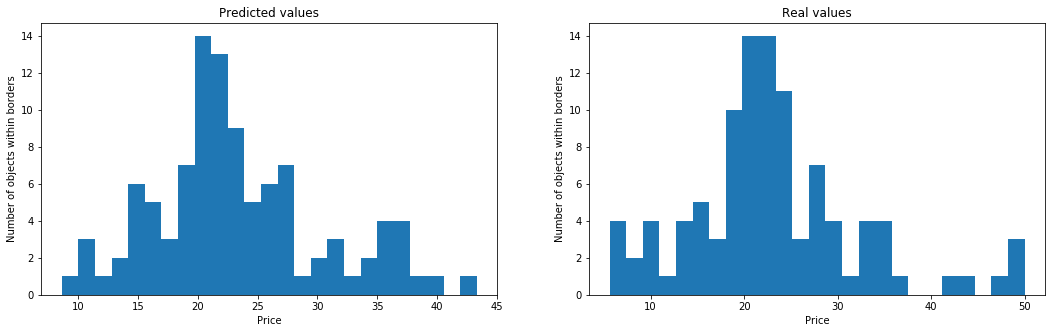

In [21]:
plt.figure(figsize=(10, 8))
fig, axs = plt.subplots(figsize=(18, 5), ncols=2)

axs[0].hist(y_pred, bins=25)
axs[0].set_title('Predicted values')
axs[0].set_ylabel('Number of objects within borders')
axs[0].set_xlabel('Price')

axs[1].hist(y_test, bins=25)
axs[1].set_title('Real values')
axs[1].set_ylabel('Number of objects within borders')
axs[1].set_xlabel('Price')

#### Расхождение результатов с реальными значениями:

Text(0.5,1,'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

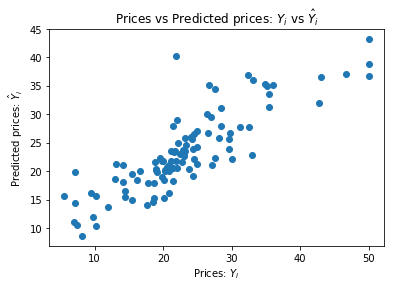

In [22]:
plt.scatter(y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

#### Построим графики зависимости ошибок от количества  элементов в тестовой выборке:

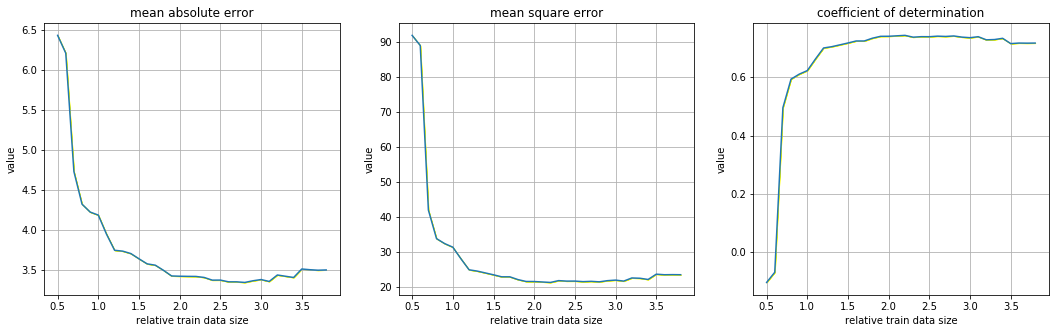

In [23]:
# varianse is negligible

plt.figure(figsize=(10, 8))
fig, axs = plt.subplots(figsize=(18, 5), ncols=3)

error = error_results_test.get('var').get('mae_var')
X, Y = parameters['l_train'], error_results_test['mae']
axs[0].plot(X, Y)
axs[0].set_title('mean absolute error')
axs[0].set_ylabel('value')
axs[0].set_xlabel('relative train data size')
axs[0].fill_between(X, np.array(Y)-np.array(error), np.array(Y)+np.array(error), color = 'YELLOW')
axs[0].grid()

error = error_results_test.get('var').get('mse_var')
Y = error_results_test['mse']
axs[1].plot(X, Y)
axs[1].set_title('mean square error')
axs[1].set_ylabel('value')
axs[1].set_xlabel('relative train data size')
axs[1].fill_between(X, np.array(Y)-np.array(error), np.array(Y)+np.array(error), color = 'YELLOW')
axs[1].grid()

error = error_results_test.get('var').get('r2_var')
Y = error_results_test['r2']
axs[2].plot(X, Y)
axs[2].set_title('coefficient of determination')
axs[2].set_ylabel('value')
axs[2].set_xlabel('relative train data size')
axs[2].fill_between(X, np.array(Y)-np.array(error), np.array(Y)+np.array(error), color = 'YELLOW')
axs[2].grid()

#### Аналогично для обучающей выборки:

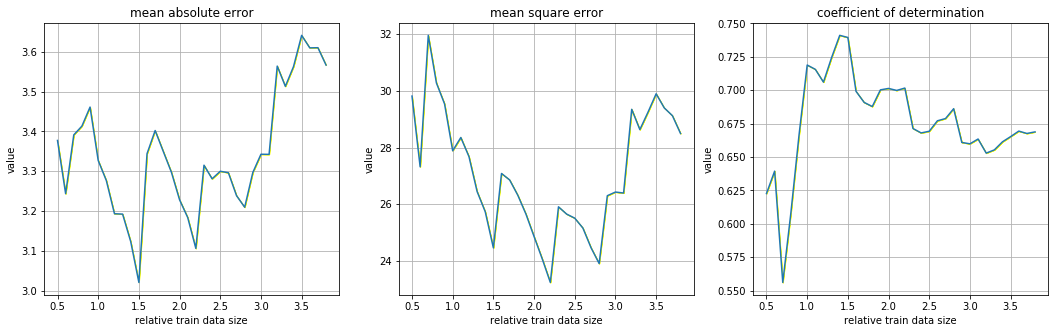

In [24]:
plt.figure(figsize=(10, 8))
fig, axs = plt.subplots(figsize=(18, 5), ncols=3)

error = error_results_train.get('var').get('mae_var')
X, Y = parameters['l_train'], error_results_train['mae']
axs[0].plot(X, Y)
axs[0].set_title('mean absolute error')
axs[0].set_ylabel('value')
axs[0].set_xlabel('relative train data size')
axs[0].fill_between(X, np.array(Y)-np.array(error), np.array(Y)+np.array(error), color = 'YELLOW')
axs[0].grid()

error = error_results_train.get('var').get('mse_var')
Y = error_results_train['mse']
axs[1].plot(X, Y)
axs[1].set_title('mean square error')
axs[1].set_ylabel('value')
axs[1].set_xlabel('relative train data size')
axs[1].fill_between(X, np.array(Y)-np.array(error), np.array(Y)+np.array(error), color = 'YELLOW')
axs[1].grid()

error = error_results_train.get('var').get('r2_var')
Y = error_results_train['r2']
axs[2].plot(X, Y)
axs[2].set_title('coefficient of determination')
axs[2].set_ylabel('value')
axs[2].set_xlabel('relative train data size')
axs[2].fill_between(X, np.array(Y)-np.array(error), np.array(Y)+np.array(error), color = 'YELLOW')
axs[2].grid()

### Выводы:

При доле обучающей выборки примерно 200-300% относительно тестовой выборки (то есть порядка 200-300 объектов) получаем параметры линейной модели, дающие наименьшие ошибки на тестовой выборке (абсолютную, квадратичную) и наивысшее значение r2-score (порядка 0,74).
Для обучающей выборки ошибка зависит от длины непонятным образом.